In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import randomized_svd

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

In [2]:
data_dir = "../data"
beta_df_filename   = f"{data_dir}/beta_df.pkl"
prec_df_filename   = f"{data_dir}/prec_df.pkl"
se_df_filename     = f"{data_dir}/se_df.pkl"
zscore_df_filename = f"{data_dir}/zscore_df.pkl"

'''
Data Frames for beta, precision, standard error and zscore.
'''

beta_df   = pd.read_pickle(beta_df_filename)
prec_df   = pd.read_pickle(prec_df_filename)
se_df     = pd.read_pickle(se_df_filename)
zscore_df = pd.read_pickle(zscore_df_filename)

trait_df = pd.read_csv(f"{data_dir}/trait_meta.csv")
phenotype_dict = trait_df.set_index('ID')['Broad'].to_dict()

In [3]:
#| code-fold: false

select_ids = beta_df.columns

X = np.array(zscore_df.replace(np.nan, 0)[select_ids]).T
colmeans = np.mean(X, axis = 0, keepdims = True)
Xcent = X - colmeans

labels = [phenotype_dict[x] for x in select_ids]
unique_labels = list(set(labels))

print (f"We have {Xcent.shape[0]} samples (phenotypes) and {Xcent.shape[1]} features (variants)")

We have 69 samples (phenotypes) and 10068 features (variants)


In [4]:
U, S, Vt = np.linalg.svd(Xcent, full_matrices = False)
print (f"Nuclear Norm of input matrix: {np.sum(S)}")

Nuclear Norm of input matrix: 7292.701186600059


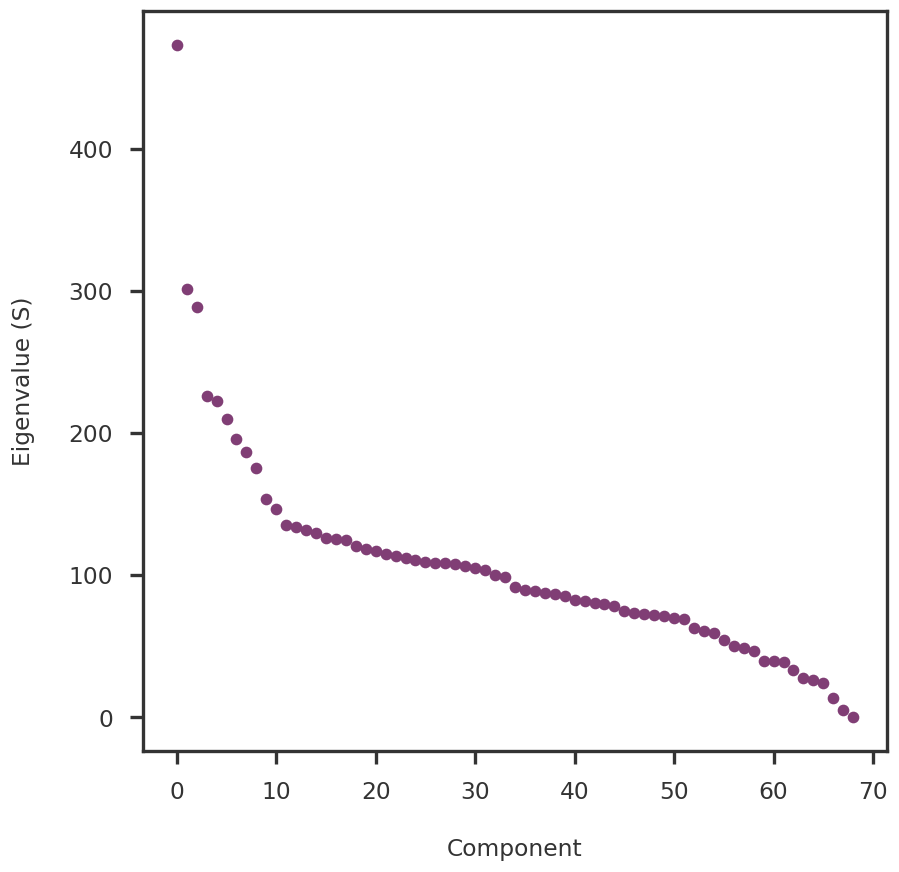

In [5]:
#| label: fig-input-eigenvalues
#| fig-cap: "Eigenvalues obtained using SVD of the input matrix"

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.arange(S.shape[0]), S)
ax1.set_xlabel("Component")
ax1.set_ylabel("Eigenvalue (S)")
plt.show()

In [6]:
#| code-fold: false

# weight = np.array(prec_df[select_ids]).T * np.array(mean_se.loc[select_ids]) * np.array(mean_se.loc[select_ids])
# weight = np.array(prec_df[select_ids]).T
weight = np.ones(X.shape)

In [79]:
#| code-fold: false

def nuclear_norm(X):
    '''
    Nuclear norm of input matrix
    '''
    return np.sum(np.linalg.svd(X)[1])

def f_objective(X, Y, W = None, mask = None):
    '''
    Objective function
    Y is observed, X is estimated
    W is the weight of each observation.
    '''
    Xmask = X if mask is None else X * mask
    Wmask = W if mask is None else W * mask
    
    # The * operator can be used as a shorthand for np.multiply on ndarrays.
    if Wmask is None:
        f_obj = 0.5 * np.linalg.norm(Y - Xmask, 'fro')**2
    else:
        f_obj = 0.5 * np.linalg.norm(Wmask * (Y - Xmask), 'fro')**2
    return f_obj


def f_gradient(X, Y, W = None, mask = None):
    '''
    Gradient of the objective function.
    '''
    Xmask = X if mask is None else X * mask
    Wmask = W if mask is None else W * mask
    
    if Wmask is None:
        f_grad = Xmask - Y
    else:
        f_grad = np.square(Wmask) * (Xmask - Y)
    
    return f_grad


def linopt_oracle(grad, r = 1.0, max_iter = 10):
    '''
    Linear optimization oracle,
    where the feasible region is a nuclear norm ball for some r
    '''
    U1, V1_T = singular_vectors_power_method(grad, max_iter = max_iter)
    S = - r * U1 @ V1_T
    return S


def singular_vectors_randomized_method(X, max_iter = 10):
    u, s, vh = randomized_svd(X, n_components = 1, n_iter = max_iter,
                              power_iteration_normalizer = 'none',
                              random_state = 0)
    return u, vh


def singular_vectors_power_method(X, max_iter = 10):
    '''
    Power method.
        
        Computes approximate top left and right singular vector.
        
    Parameters:
    -----------
        X : array {m, n},
            input matrix
        max_iter : integer, optional
            number of steps
            
    Returns:
    --------
        u, v : (n, 1), (p, 1)
            two arrays representing approximate top left and right
            singular vectors.
    '''
    n, p = X.shape
    u = np.random.normal(0, 1, n)
    u /= np.linalg.norm(u)
    v = X.T.dot(u)
    v /= np.linalg.norm(v)
    for _ in range(max_iter):      
        u = X.dot(v)
        u /= np.linalg.norm(u)
        v = X.T.dot(u)
        v /= np.linalg.norm(v)       
    return u.reshape(-1, 1), v.reshape(1, -1)


def do_step_size(dg, D, W = None):
    if W is None:
        denom = np.linalg.norm(D, 'fro')**2
    else:
        denom = np.linalg.norm(W * D, 'fro')**2
    step_size = dg / denom
    step_size = min(step_size, 1.0)
    if step_size < 0:
        print ("Warning: Step Size is less than 0")
        step_size = 1.0
    return step_size


def frank_wolfe_minimize_step(X, Y, r, istep, W = None, mask = None):
    
    # 1. Gradient for X_(t-1)
    G = f_gradient(X, Y, W = W, mask = mask)
    # 2. Linear optimization subproblem
    power_iter = 10 + int(istep / 50)
    S = linopt_oracle(G, r, max_iter = power_iter)
    # 3. Define D
    D = X - S
    # 4. Duality gap
    dg = np.trace(D.T @ G)
    # 5. Step size
    step = do_step_size(dg, D, W = W)
    # 6. Update
    Xnew = X - step * D
    return Xnew, G, dg, step


def frank_wolfe_minimize(Y, r, X0 = None,
                         weight = None,
                         mask = None,
                         max_iter = 1000, tol = 1e-8,
                         return_all = True,
                         debug = False, debug_step = 10):
    
    # Step 0
    old_X = np.zeros_like(Y) if X0 is None else X0.copy()
    dg = np.inf

    if return_all:
        dg_list = [dg]
        fx_list = [f_objective(old_X, Y, W = weight, mask = mask)]
        st_list = [1]
        
    # Steps 1, ..., max_iter
    for istep in range(max_iter):
        X, G, dg, step = \
            frank_wolfe_minimize_step(old_X, Y, r, istep, W = weight, mask = mask)
        f_obj = f_objective(X, Y, W = weight, mask = mask)

        if return_all:
            dg_list.append(dg)
            fx_list.append(f_obj)
            st_list.append(step)
        
        if debug:
            if (istep % debug_step == 0):
                print (f"Iteration {istep}. Step size {step:.3f}. Duality Gap {dg:g}")
        if np.abs(dg) <= tol:
            break
            
        old_X = X.copy()
        
    if return_all:
        return X, dg_list, fx_list, st_list
    else:
        return X

In [80]:
X_opt, dg_list, fx_list, step_list = frank_wolfe_minimize(Xcent, 100.0, max_iter = 10, debug = True, debug_step = 1)

Iteration 0. Step size 1.000. Duality Gap 47280.8
Iteration 1. Step size 1.000. Duality Gap -0.17212
Iteration 2. Step size 1.000. Duality Gap -9.51455
Iteration 3. Step size 1.000. Duality Gap -11.2205
Iteration 4. Step size 0.386. Duality Gap 582.621
Iteration 5. Step size 1.000. Duality Gap 143.495
Iteration 6. Step size 0.671. Duality Gap 47.3667
Iteration 7. Step size 1.000. Duality Gap -454.516
Iteration 8. Step size 0.529. Duality Gap 1893.78
Iteration 9. Step size 1.000. Duality Gap 419.05


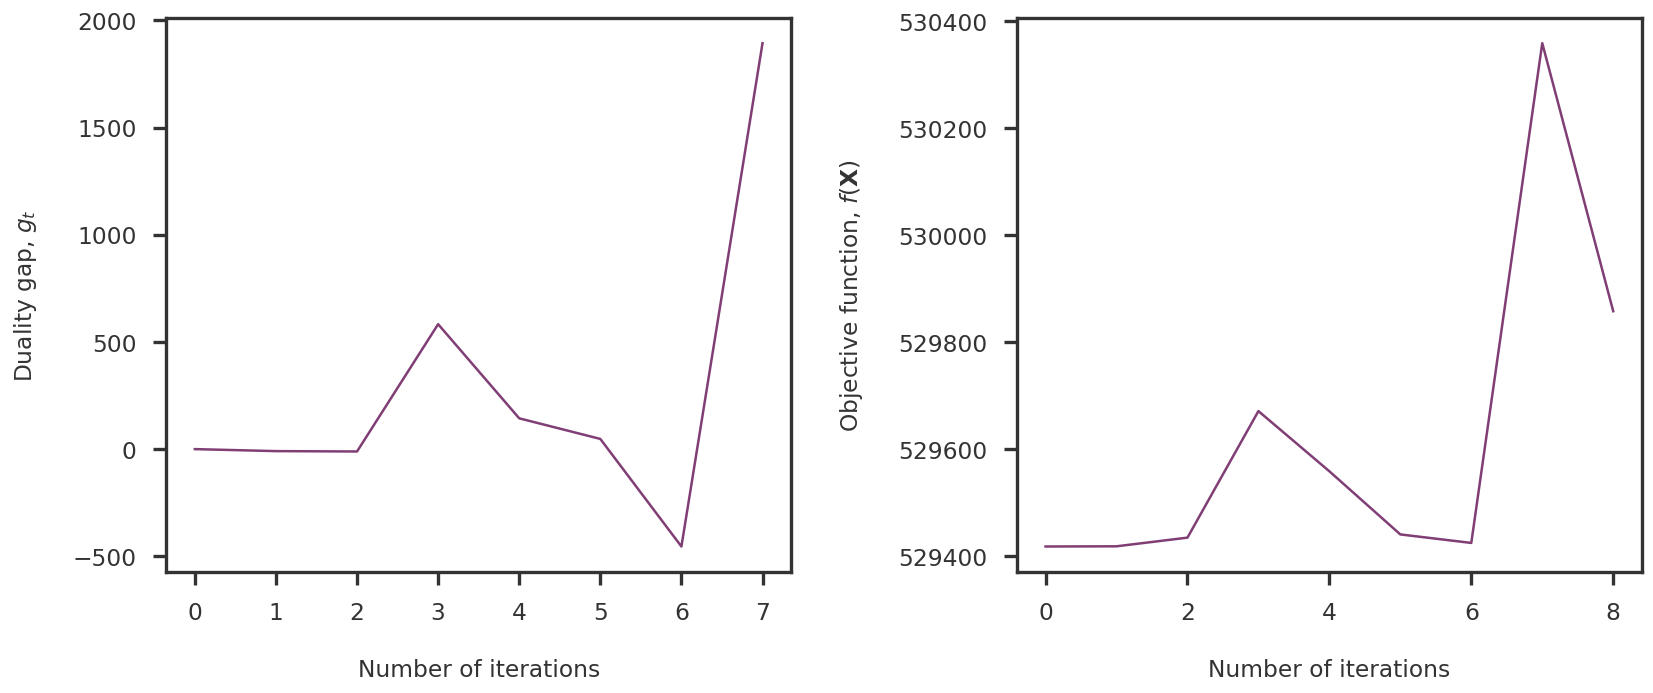

In [81]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

kp = 10
ax1.plot(np.arange(kp - 2), dg_list[2:kp])
ax2.plot(np.arange(kp - 1), fx_list[1:kp])

ax1.set_xlabel("Number of iterations")
ax2.set_xlabel("Number of iterations")
ax1.set_ylabel(r"Duality gap, $g_t$")
ax2.set_ylabel(r"Objective function, $f(\mathbf{X})$")
fig.tight_layout(w_pad = 2.0)
plt.show()

In [62]:
np.linalg.matrix_rank(X_opt)

3

In [63]:
nuclear_norm(X_opt)

99.99956475737909

In [64]:
X_opt_cent = X_opt - np.mean(X_opt, axis = 0, keepdims = True)
U_fw, S_fw, Vt_fw = np.linalg.svd(X_opt_cent)
pca_fw = U_fw @ np.diag(S_fw)

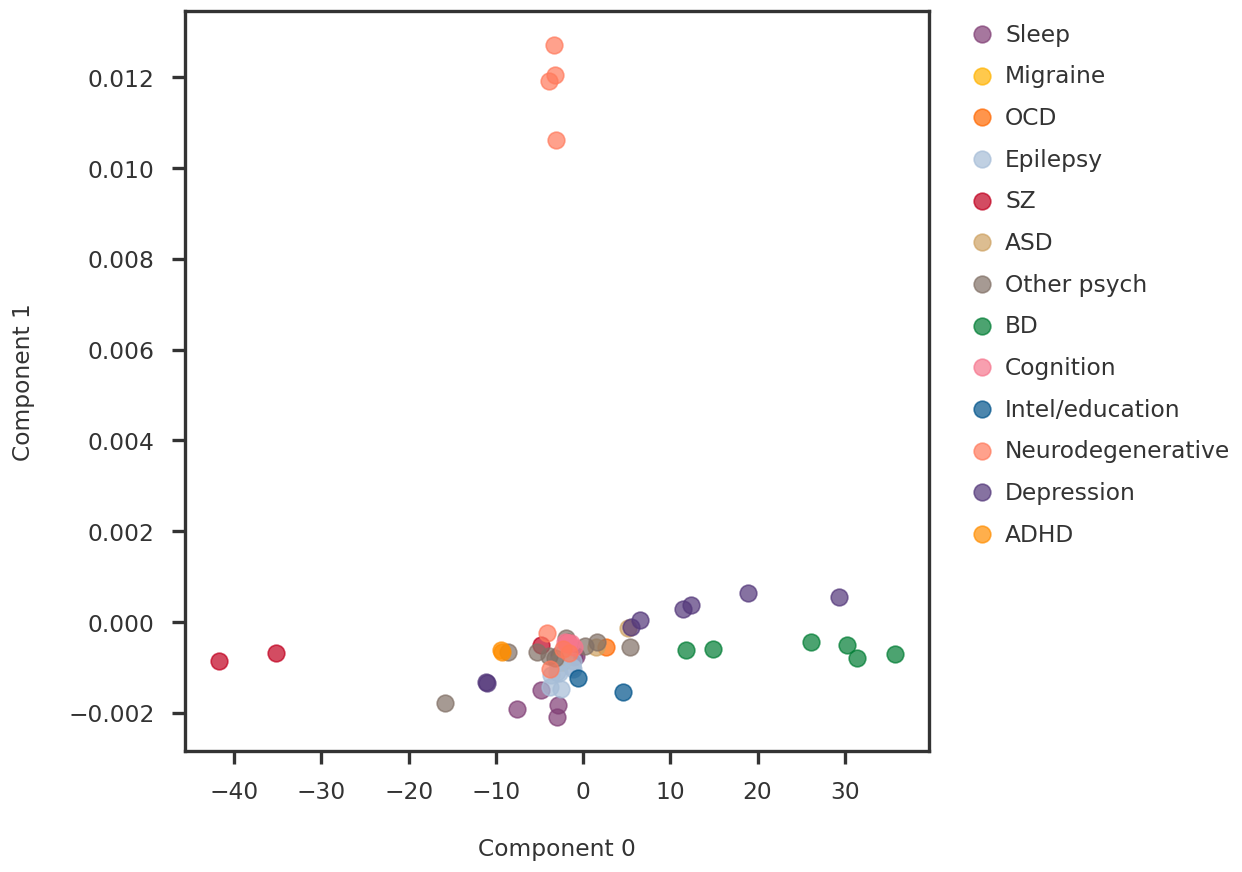

In [65]:
idx1 = 0
idx2 = 1
svd_pc1 = pca_fw[:, idx1]
svd_pc2 = pca_fw[:, idx2]

fig = plt.figure()
ax1 = fig.add_subplot(111)

for label in unique_labels:
    idx = np.array([i for i, x in enumerate(labels) if x == label])
    ax1.scatter(svd_pc1[idx], svd_pc2[idx], s = 100, alpha = 0.7, label = label)
    
ax1.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax1.set_xlabel(f"Component {idx1}")
ax1.set_ylabel(f"Component {idx2}")
plt.show()